In [26]:
import numpy as np

# Example matrix X
X = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

# Number of repetitions per column
h = 2

# Repeat each column h times
X_repeated = np.repeat(X, h, axis=1)

print("Original Matrix X:")
print(X)

print("\nNew Matrix with Columns Repeated:")
print(X_repeated)


Original Matrix X:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

New Matrix with Columns Repeated:
[[1 1 2 2 3 3]
 [4 4 5 5 6 6]
 [7 7 8 8 9 9]]


In [3]:
import numpy as np

# Example matrix X
X = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

# Number of repetitions per column
h = 2

# Repeat X h times
X_repeated = np.tile(X, (1, h))

print("Original Matrix X:")
print(X)

print("\nNew Matrix with Columns Repeated:")
print(X_repeated)


Original Matrix X:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

New Matrix with Columns Repeated:
[[1 2 3 1 2 3]
 [4 5 6 4 5 6]
 [7 8 9 7 8 9]]


In [1]:
import numpy as np

# Example matrix (shape a, b)
matrix = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

# Flatten the matrix by columns (column-major order)
flattened = matrix.flatten(order='F')  # 'F' means Fortran-style (column-major)

print("Original Matrix:")
print(matrix)

print("\nFlattened Matrix by Columns:")
print(flattened)


Original Matrix:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

Flattened Matrix by Columns:
[1 4 7 2 5 8 3 6 9]


In [6]:
import numpy as np
import scipy.io as sio
mout = sio.loadmat('mout.mat')['mout']
m = mout.reshape(800,5)

print(m[:100])

[[5.26855601e-13 7.71309604e-13 2.40527328e-01 8.94124126e-02
  3.34081420e-12]
 [3.31762139e-12 3.53820165e-02 2.92493283e-12 1.48692832e-01
  6.76592397e-02]
 [1.18409013e-12 1.72668113e-02 6.79217990e-13 7.28377962e-13
  7.10668716e-13]
 [3.95237539e-03 1.60235345e-12 5.11427879e-13 1.24696674e-02
  1.08185210e-02]
 [4.23727430e-03 1.92085460e-01 7.52244344e-13 6.50236865e-13
  9.80500581e-13]
 [1.90159801e-01 1.43297535e-02 3.38034976e-02 4.73556584e-02
  7.25038764e-13]
 [2.60646300e-11 1.20699616e-01 1.69116550e-12 5.50684721e-13
  7.18446424e-12]
 [2.49026541e-02 8.19347044e-02 1.02787386e-01 9.05429384e-02
  1.91318201e-03]
 [7.12464224e-02 1.08477326e-01 4.99849961e-02 1.39293271e-01
  5.35205353e-12]
 [5.02957529e-02 1.13214320e-01 2.06850630e-12 2.10543193e-12
  6.22526080e-02]
 [2.93406091e-02 6.29748967e-02 1.22062606e-01 7.89929458e-02
  9.82217099e-03]
 [1.29067063e-01 9.52459822e-02 7.85650550e-02 2.17075889e-05
  2.05077275e-02]
 [6.40072385e-02 4.99850151e-02 1.357332

In [8]:
import numpy as np
import scipy.io as sio
mout = sio.loadmat('mout.mat')['mout']
m = mout.reshape(800,5)

print(m[-100:])

[[1.03398414e-12 1.38861325e-02 4.32815322e-02 1.16259187e-02
  3.85543429e-02]
 [1.88589386e-11 1.13033554e-01 1.39761257e-02 1.87444121e-01
  7.96672045e-02]
 [7.98858952e-13 5.47467976e-12 1.48284422e-11 2.95518035e-12
  2.95770564e-12]
 [1.87584673e-01 1.40455580e-12 8.64334602e-13 3.27665274e-12
  1.42902227e-02]
 [1.55463986e-12 1.09463944e-12 8.68102569e-12 7.20101559e-13
  5.57011351e-03]
 [2.56142771e-12 7.70463487e-13 1.00463087e-12 4.45717148e-02
  9.94344933e-02]
 [3.07085310e-02 9.97596105e-13 5.70207449e-02 1.16213677e-12
  3.66166933e-02]
 [1.21918546e-01 6.97333936e-02 5.37277055e-03 1.55648603e-01
  3.73593055e-02]
 [1.23282025e-12 2.48243392e-02 7.01039889e-02 1.88710898e-12
  4.43021786e-02]
 [1.05517718e-12 5.20405971e-13 9.47533728e-13 9.30192667e-13
  1.58975866e-02]
 [8.00692484e-13 1.55172645e-12 1.14799336e-02 1.30781048e-12
  8.79290306e-13]
 [9.00739129e-13 7.91709480e-02 6.36316563e-02 3.88569020e-02
  6.21071701e-13]
 [2.17277422e-02 1.01021872e-12 2.456570

In [9]:
print(m[:100])

[[5.26855601e-13 7.71309604e-13 2.40527328e-01 8.94124126e-02
  3.34081420e-12]
 [3.31762139e-12 3.53820165e-02 2.92493283e-12 1.48692832e-01
  6.76592397e-02]
 [1.18409013e-12 1.72668113e-02 6.79217990e-13 7.28377962e-13
  7.10668716e-13]
 [3.95237539e-03 1.60235345e-12 5.11427879e-13 1.24696674e-02
  1.08185210e-02]
 [4.23727430e-03 1.92085460e-01 7.52244344e-13 6.50236865e-13
  9.80500581e-13]
 [1.90159801e-01 1.43297535e-02 3.38034976e-02 4.73556584e-02
  7.25038764e-13]
 [2.60646300e-11 1.20699616e-01 1.69116550e-12 5.50684721e-13
  7.18446424e-12]
 [2.49026541e-02 8.19347044e-02 1.02787386e-01 9.05429384e-02
  1.91318201e-03]
 [7.12464224e-02 1.08477326e-01 4.99849961e-02 1.39293271e-01
  5.35205353e-12]
 [5.02957529e-02 1.13214320e-01 2.06850630e-12 2.10543193e-12
  6.22526080e-02]
 [2.93406091e-02 6.29748967e-02 1.22062606e-01 7.89929458e-02
  9.82217099e-03]
 [1.29067063e-01 9.52459822e-02 7.85650550e-02 2.17075889e-05
  2.05077275e-02]
 [6.40072385e-02 4.99850151e-02 1.357332

In [40]:
m_grouped = mout.reshape(300, 5)
feature_prob = np.sum(m_grouped, axis=1)
feature_rank = np.argsort(np.abs(feature_prob))[::-1]
selected_features_predict = feature_rank[:20]
clusters_predict = {}
for i in selected_features_predict:
    cluster = np.argmax(m_grouped[i])
    print("the feature", m_grouped[i])
    print("the maximum probability", m_grouped[i][cluster])
    print("the sum of the probability", np.sum(m_grouped[i]))
    print("cluster", cluster)
    if cluster in clusters_predict:
        clusters_predict[cluster].append(i)
    else:
        clusters_predict[cluster] = [i]

the feature [0.015631 0.015631 0.015631 0.015631 0.015631]
the maximum probability 0.015631002748355164
the sum of the probability 0.07815501374177582
cluster 0
the feature [0.01549332 0.01549332 0.01549332 0.01549332 0.01549332]
the maximum probability 0.015493315928677706
the sum of the probability 0.07746657964338853
cluster 0
the feature [0.01494724 0.01494724 0.01494724 0.01494724 0.01494724]
the maximum probability 0.014947238456430105
the sum of the probability 0.07473619228215053
cluster 0
the feature [0.01484699 0.01484699 0.01484699 0.01484699 0.01484699]
the maximum probability 0.014846993507582685
the sum of the probability 0.07423496753791342
cluster 0
the feature [0.01154592 0.01154592 0.01154592 0.01154592 0.01154592]
the maximum probability 0.011545919979338234
the sum of the probability 0.05772959989669117
cluster 0
the feature [0.01142099 0.01142099 0.01142099 0.01142099 0.01142099]
the maximum probability 0.011420993435985126
the sum of the probability 0.057104967179

In [37]:
def random_partition(d, h_total):
    """
    Randomly partition `d` into `h_total` parts, ensuring the sum equals `d`.
    
    Parameters:
    - d (int): Total number to partition.
    - h_total (int): Number of parts/clusters.

    Returns:
    - list: A list of breakpoints that divide the range [0, d] into `h_total` parts.
    """
    if d < h_total:
        raise ValueError("The number of clusters exceeds the total number.") 
    # Generate `h_total - 1` random breakpoints in the range [0, d]
    breakpoints = sorted(np.random.choice(range(1, d), h_total - 1, replace=False))
    
    # Add the boundaries (0 and d) to the breakpoints
    breakpoints = [0] + breakpoints + [d]

    # print("cluster 0 contains features from 0 to", breakpoints[1] - 1)  
    for i in range(h_total):
        print(f"cluster {i} contains features from {breakpoints[i]} to {breakpoints[i + 1] - 1}")

    
    return breakpoints

random_partition(200, 5)

cluster 0 contains features from 0 to 80
cluster 1 contains features from 81 to 107
cluster 2 contains features from 108 to 152
cluster 3 contains features from 153 to 197
cluster 4 contains features from 198 to 199


[0, 81, 108, 153, 198, 200]

In [25]:
import numpy as np
d = 10
h = 5
# m = np.zeros((d*h, 1))
M = np.zeros((d, h))
for i in range(d):
    # choose a cluster randomly
    cluster = np.random.choice(h)
    M[i, cluster] = 1

print(M)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [29]:
M = np.ones((d, h)) * 1/h
print(M)

[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]


In [21]:
print(MTM)

[[0.4 0.4 0.4 0.4 0.4]
 [0.4 0.4 0.4 0.4 0.4]
 [0.4 0.4 0.4 0.4 0.4]
 [0.4 0.4 0.4 0.4 0.4]
 [0.4 0.4 0.4 0.4 0.4]]


In [30]:
frobenius_norm_squared = np.sum(M**2)
diag_sum = np.sum(np.einsum('ij,ij->j', M, M))  # Diagonal elements of M.T @ M
correction_term = 0.5 * (frobenius_norm_squared - diag_sum)
correction_term 

3.3306690738754696e-16

In [31]:
# M = m.reshape(d, h)
C = 1
# M = 0.2 * np.ones((d, h))
# Step 1: Compute M M^T (row-wise sums of all pairwise products)
MTM = np.dot(M.T, M)
correction_term = np.sum(MTM) - np.sum(np.diag(MTM))
print(correction_term)
# Step 1: Compute row-wise sums
row_sums = np.sum(M, axis=1, keepdims=True)  # Shape (n_rows, 1)

# Step 2: Compute the gradient
gradient = row_sums - M

# correction_term = C * np.sum(m**2)
print(gradient)


8.0
[[0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]]


In [18]:
MTM = np.dot(M.T, M)
correction_term = np.sum(MTM) - np.sum(np.diag(MTM))
print(correction_term)

0.0


In [10]:
import numpy as np

def vector_to_symmetric(vec, n):
    """
    Convert a vector of independent variables to a symmetric matrix.
    """
    sym_matrix = np.zeros((n, n), dtype=int)
    upper_indices = np.triu_indices(n)
    sym_matrix[upper_indices] = vec
    sym_matrix = sym_matrix + sym_matrix.T - np.diag(np.diag(sym_matrix))
    return sym_matrix

def compute_upper_triangle_product(L, vec, n):
    """
    Compute the product L_ij * y_ij for the upper triangular part of the symmetric matrix.
    """
    # Reconstruct the symmetric matrix from the vector
    sym_matrix = vector_to_symmetric(vec, n)
    
    # Extract the upper triangular indices
    upper_indices = np.triu_indices(n)
    
    # Compute L_ij * y_ij for upper triangular elements
    product_upper = L[upper_indices] * sym_matrix[upper_indices]
    
    # Return the product as a flat vector
    return product_upper

# Example
n = 3  # Dimension of the symmetric matrix

# Define L as a symmetric matrix
L = np.array([
    [1, 2, 3],
    [2, 4, 5],
    [3, 5, 6]
])

# Define vec as the upper triangular entries of a symmetric matrix
vec = np.array([1, 0, 1, 0, 1, 0])  # Corresponds to the symmetric matrix:
# [[1, 0, 1],
#  [0, 1, 0],
#  [1, 0, 0]]

# Compute the product
upper_product = compute_upper_triangle_product(L, vec, n)

# Print results
print("Matrix L:")
print(L)
print("\nReconstructed symmetric matrix from vec:")
print(vector_to_symmetric(vec, n))
print("\nFlattened upper triangular product vector (L_ij * y_ij):")
print(upper_product)

Matrix L:
[[1 2 3]
 [2 4 5]
 [3 5 6]]

Reconstructed symmetric matrix from vec:
[[1 0 1]
 [0 0 1]
 [1 1 0]]

Flattened upper triangular product vector (L_ij * y_ij):
[1 0 3 0 5 0]


In [11]:
import numpy as np
from gurobipy import Model, GRB, quicksum

def projection_operator_upper_triangle(vec, n, k):
    """
    Projects the upper triangular part of a matrix represented by 'vec'
    onto the constraint set:
    - sum(y_ii) <= k
    - 0 < y_ij < 1 for all elements
    
    Parameters:
    - vec: (n * (n + 1)) / 2 numpy array, upper triangular part of the matrix.
    - n: Integer, size of the matrix (n x n).
    - k: Integer, maximum sum of diagonal elements.
    
    Returns:
    - vec_proj: Projected upper triangular part as a flattened vector.
    """
    # Reconstruct the full matrix from the upper triangular vector
    Y = np.zeros((n, n))
    indices = np.triu_indices(n)
    Y[indices] = vec
    Y = Y + Y.T - np.diag(np.diag(Y))  # Fill lower triangular to make symmetric

    # Gurobi optimization
    model = Model("Projection")
    model.setParam("OutputFlag", 0)  # Suppress Gurobi output

    # Define variables for upper triangular part
    y = model.addVars(n, n, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="y")

    # Objective: Minimize ||Y - y||_F^2
    model.setObjective(
        quicksum((Y[i, j] - y[i, j]) ** 2 for i in range(n) for j in range(i, n)),
        GRB.MINIMIZE
    )

    # Constraint 1: sum(y_ii) <= k
    model.addConstr(quicksum(y[i, i] for i in range(n)) <= k, name="DiagonalSum")

    # Optimize the model
    model.optimize()

    # Extract the projected matrix
    Y_proj = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            Y_proj[i, j] = y[i, j].x
            Y_proj[j, i] = Y_proj[i, j]  # Symmetric

    # Extract the upper triangular part of the projected matrix
    vec_proj = Y_proj[indices]

    return vec_proj

# Example usage
n = 4  # Matrix size
k = 2  # Sum of diagonal constraint

# Example input vector (upper triangular part of the matrix)
vec = np.array([0.8, 0.5, 0.2, 0.4, 0.6, 0.7, 0.3, 0.9, 0.8, 0.5])

vec_proj = projection_operator_upper_triangle(vec, n, k)
print("Original upper triangular vector:")
print(vec)
print("\nProjected upper triangular vector:")
print(vec_proj)

Set parameter Username
Set parameter LicenseID to value 2585252
Set parameter LogToConsole to value 0
Original upper triangular vector:
[0.8 0.5 0.2 0.4 0.6 0.7 0.3 0.9 0.8 0.5]

Projected upper triangular vector:
[0.6 0.5 0.2 0.4 0.4 0.7 0.3 0.7 0.8 0.3]


In [13]:
Xs = np.array([
    [1, 1, 0, 0],
    [1, 1, 1, 0],
    [0, 1, 1, 1],
    [0, 0, 1, 1]
])

i = 1  # We are checking the relationships for feature 1
Xs_ij = Xs[i, :]  # Extract the i-th row
buddy = np.where(Xs_ij == 1)[0]  # Get the indices of features in the same cluster
print("Row:", Xs_ij)
print("Buddy indices:", buddy)

Row: [1 1 1 0]
Buddy indices: [0 1 2]


In [ ]:
import numpy as np
import scipy.io as sio
from utils.vec_mat import vector_to_symmetric
Xs_out = sio.loadmat("Xs_out.mat")["Xs_out"]

Xs = vector_to_symmetric(Xs_out, 500)


In [47]:
print(Xs[:5, :5])   

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [48]:
print(np.diag(Xs))

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99999797 1.
 1.         1.         1.         1.         1.         1.
 1.         0.99999999 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.67715827
 0.63965588 0.59658693 0.61322264 0.65407512 0.62802866 0.60998185
 0.57051293 0.63448865 0.61820188 0.60728501 0.62383956 0.60410057
 0.62487718 0.60698872 0.63368641 0.60740782 0.61455232 0.62571443
 0.66667722 0.68775957 0

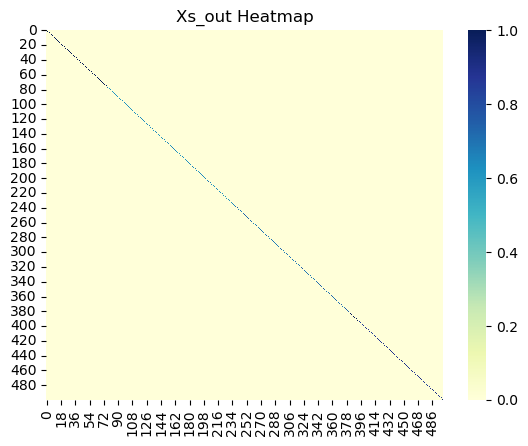

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot a heatmap of the Xs_out matrix

sns.heatmap(Xs, cmap="YlGnBu")
plt.title("Xs_out Heatmap")

plt.show()

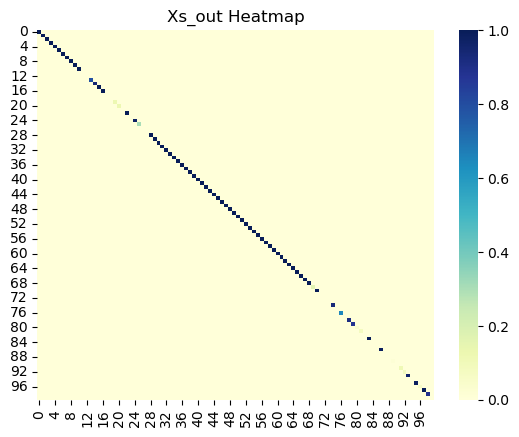

In [52]:
import numpy as np
import scipy.io as sio
Xs_out = sio.loadmat("Xs_out.mat")["Xs_out"]

Xs = vector_to_symmetric(Xs_out, 100)
sns.heatmap(Xs, cmap="YlGnBu")
plt.title("Xs_out Heatmap")

plt.show()

In [10]:
from L0Obj import L0Obj, L0Obj_separate
import numpy as np
from data_generator import read_synthetic_data
m = np.random.normal(0, 1, (2500, 1))
n = 1000  # Number of samples
d = 500   # Number of features
# k = 20  # Number of non-zero features
h_total = 5    # number of cluster in the graph
h = 5 # number of cluster that are selected i.e. related to the dependent variable
nVars = d*h # Number of Boolean variables in m
inter_cluster = 1 # probability of inter-cluster edges in graph
outer_cluster = 0.0 # probability of outer-cluster edges in graph
gamma = 1.5  # Noise standard deviation

mu = 1
pho = 1
file_path = "data/synthetic_data.pkl"
print("Fixed seed is enabled. Reading synthetic data from file.")
# Read synthetic data from the saved files
X, w_true, y, adj_matrix, L, clusters_true, k = read_synthetic_data(file_path)
X_hat = np.repeat(X, h, axis=1)
f, g, graph_penalty, precision_penalty, correction_term, A_grad, B_grad, C_grad = L0Obj_separate(X_hat, m, y, L, pho, mu, d, h, n)
print(f"obj: {f}, graph_penalty: {graph_penalty}, precision_penalty: {precision_penalty}, correction_term: {correction_term}")
print(f"A_grad: {A_grad}, B_grad: {B_grad}, C_grad: {C_grad}")

Fixed seed is enabled. Reading synthetic data from file.
Reading synthetic data from file: data/synthetic_data.pkl
Loaded data:
  X shape: (1000, 500)
  w shape: (500,)
  y shape: (1000,)
  adj_matrix shape: (500, 500)
  laplacian_matrix shape: (500, 500)
  clusters length: 5
  k: 500
obj: 247162.43647811853, graph_penalty: 152581.77249468496, precision_penalty: 258.3555145409817, correction_term: 94322.30846889259
A_grad: [-0.19664176 -0.19664176 -0.19664176 ... -8.5207326  -8.5207326
 -8.5207326 ], B_grad: [  61.93763902  -13.96818826   31.48947997 ...   39.08474803 -152.15132938
    9.47083661], C_grad: [ -681.97698089 -2024.2144941  -1307.67074695 ...  2888.63584838
   512.90857752  2516.92861857]


In [11]:
k = np.arange(1, 49)
e = 1 + (49 - k)/4
print(e.sum())

342.0


In [13]:
342/49

6.979591836734694

In [16]:
# simulate the expected number of cards you should turn before finding second ace withou replacement
import numpy as np
n = 1000000
res = []
aces = set([1,2,3,4])
for i in range(n):
    n_ace = 0
    n_turn = 0
    cards_perm = np.random.permutation(52)
    # assume 1,2,3,4 are aces
    for card in cards_perm:
        n_turn += 1
        if card in aces:
            n_ace += 1
            if n_ace == 4:
                break

    res.append(n_turn)

print(np.mean(res))

42.402516


Fixed seed is enabled. Reading synthetic data from file.
Reading synthetic data from file: data/synthetic_data.pkl
Loaded data:
  X shape: (2000, 400)
  w shape: (400,)
  y shape: (2000,)
  adj_matrix shape: (400, 400)
  laplacian_matrix shape: (400, 400)
  clusters length: 10
  k: 36


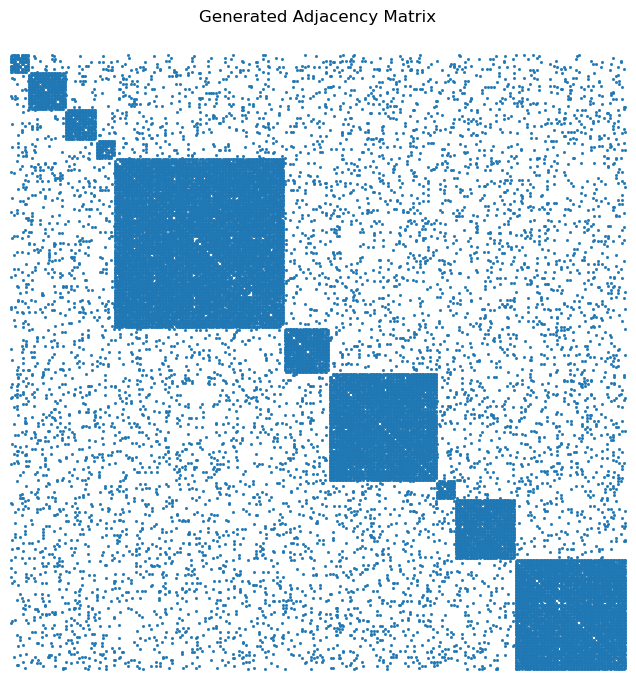

In [10]:
import numpy as np
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.stats import multivariate_normal
import time

from L0Obj import L0Obj, L0Obj_separate
from data_generator import generate_synthetic_data_with_graph, read_synthetic_data, save_synthetic_data
from ProjectOperator import ProjOperator_Gurobi, check_feasibility_with_gurobi
from minConf.minConf_PQN_mod import minConF_PQN
import random
# import matlab.engine

tStart = time.process_time()
# Generate synthetic data
# Parameters
n = 2000  # Number of samples
d = 400   # Number of features
# k = 20  # Number of non-zero features
h_total = 10    # number of cluster in the graph
h = 2 # number of cluster that are selected i.e. related to the dependent variable
nVars = d*h # Number of Boolean variables in m
inter_cluster = 0.9 # probability of inter-cluster edges in graph
outer_cluster = 0.05 # probability of outer-cluster edges in graph
gamma = 1.5  # Noise standard deviation

mu = 1

SNR = 1

fixed_seed = 1
random_rounding = 0
connected = False
correlated = True
random_graph = True
visualize = True

if fixed_seed:
    file_path = "data/synthetic_data.pkl"
    print("Fixed seed is enabled. Reading synthetic data from file.")
    # Read synthetic data from the saved files
    X, w_true, y, adj_matrix, L, clusters_true, k = read_synthetic_data(file_path, visualize=visualize)
else:
    print("Fixed seed is disabled. Generating synthetic data.")
    # Generate synthetic data
    X, w_true, y, adj_matrix, L, clusters_true, k = generate_synthetic_data_with_graph(
        n, d, h_total, h,
        inter_cluster=inter_cluster,
        outer_cluster=outer_cluster,
        gamma=gamma,
        visualize=visualize,
        connected=connected,
        random=random_graph
    )
    
    # Save synthetic data to files for future use
    file_path = "data/synthetic_data.pkl"
    save_synthetic_data(file_path, X, w_true, y, adj_matrix, L, clusters_true, k)
    print("Synthetic data has been saved.")

In [14]:
# maximal diagonal element of L, L is a sparse matrix
max_L = max(L.diagonal())


In [15]:
max_L

122.0